# Udacity Project 4 Advanced Lane Finding


The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import Libs and setting which examples to plot

In [11]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import re

plot_demos = 0 # set this to 0 to plot all examples, >8 => direct video creating
    
# %matplotlib
%matplotlib inline

## Helper functions

In [12]:
def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    key_no = [tryint(c) for c in re.split('([0-9]+)', s) ]
    key_no = int(key_no[1])
    return key_no

def sort_nicely(liste):
    """ Sort the given list in the way that humans expect.
    """
    liste.sort(key=alphanum_key)
    return liste

def plot_two_images(img, img_aug, size=(13,5), set_axis = 'off',show = 1, titles = [' ',' ']):
    """ Plots two images side by side 
    """
    f = plt.figure(figsize=size)
    ysize = img.shape[0]
    xsize = img.shape[1]
    
    ax1 = plt.subplot(121)
    plt.axis(set_axis)
    plt.imshow(img, cmap='inferno')
    plt.title(titles[0])
    ax1.set_ylim(ysize, 0)
    ax1.set_xlim(0, xsize)
    
    ax2 = plt.subplot(122)
    plt.axis(set_axis)
    plt.imshow(img_aug, cmap='inferno')
    plt.title(titles[1])
    plt.subplots_adjust(top=1.0,bottom=0.0,left=0.0,right=1.0,hspace=0.05,wspace=0.05)
    ax2.set_ylim(ysize, 0)
    ax2.set_xlim(0, xsize)
    
    if show:
        plt.show()
    return f, ax1, ax2

   
def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:

        if (img.max() <= 1 or img.max() > 255) and img.min() <= 0  :
            ignore_mask_color = 1
        elif (img.max()) > 1:
            ignore_mask_color = 255

    vertices  = np.array(vertices, ndmin = 3, dtype = np.int32)
    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def weighted_img(initial_img, alpha, img, beta, λ=0.):
    return cv2.addWeighted(initial_img, alpha, img, beta, λ)

def norm_0_255(img):
    """ Normalize img input to range from int 0 to 255
    """

    img_min = np.min(img)
    img_max = np.max(img)
    range_img = img_max - img_min
    result = (img-img_min)/range_img*255
    return(np.asarray(result, dtype='uint8'))

def norm_0_1(img):
    """ Normalize img input to range from float 32 0 to 1
    """    
    if img.max() > 1 or img.max() < 1 or img.min() <= 0:
        img_min = np.min(img)
        img_max = np.max(img)
        range_img = img_max - img_min
        result = (img-img_min)/range_img
        return(np.asarray(result, dtype='float32'))
    else:
        print("+++WARNING Normalizing to range 0 - 1: image has already a maximum <= 1")
        return img

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)



## Calibration & Edge Enhancement

In [13]:
def edge_enhancement(img, max_value=8):
    """OpenCV with Python By Example by Prateek Joshi
    """

    kernel = np.array([[-1,-1,-1,-1,-1],
                         [-1,2,2,2,-1],
                         [-1,2,max_value,2,-1],
                         [-1,2,2,2,-1],
                         [-1,-1,-1,-1,-1]]) / max_value

    output = cv2.filter2D(img,-1,kernel)

    return output

In [14]:
use_dumped_cali_file = 1 # if set to 1 use calibration_file.p file

if use_dumped_cali_file:
    with open('calibration_file.p', mode='rb') as handle:
        cali_file = pickle.load(handle)
    mtx = cali_file['mtx']
    dist = cali_file['dist']
else:
    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for img_name in images:
        img = mpimg.imread(img_name)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        gray = edge_enhancement(gray)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    ### dump into .p-file
    cali_file = {'mtx' : mtx, 'dist': dist}

    with open('calibration_file.p', 'wb') as handle:
        pickle.dump(cali_file, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def undistort_img(img, mtx = mtx, dist = dist):
    return cv2.undistort(img, mtx, dist, None, mtx)


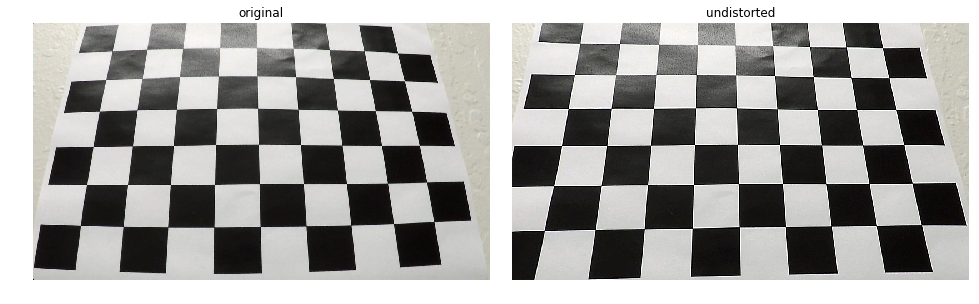

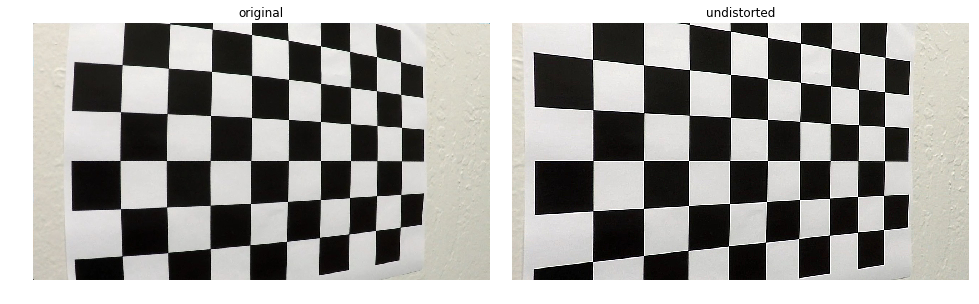

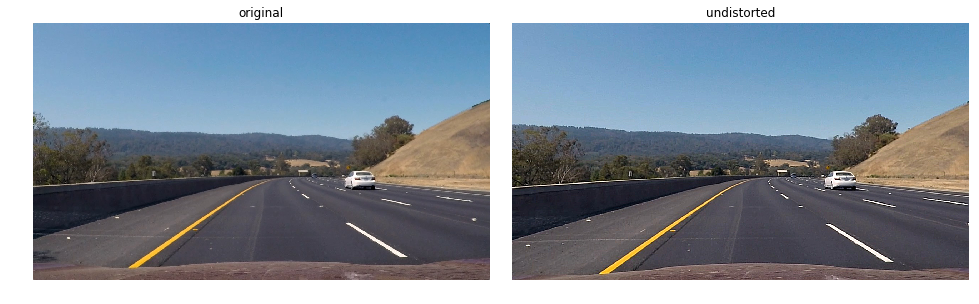

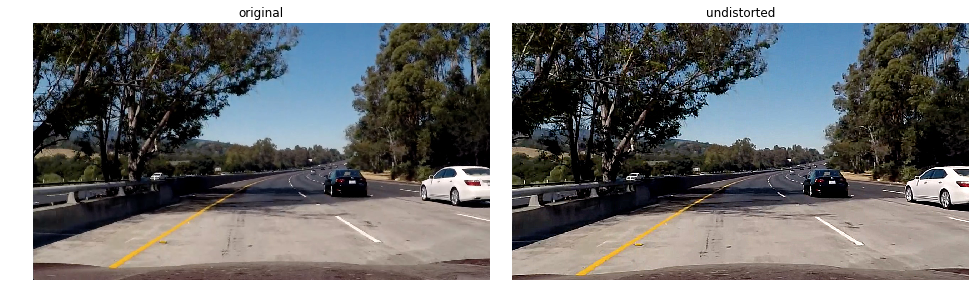

In [15]:
# Demo
img = mpimg.imread('./camera_cal/calibration3.jpg')
dst = undistort_img(img, mtx, dist)
dst = edge_enhancement(dst)
if plot_demos <= 1 : 
    plot_two_images(img, dst, titles = ['original','undistorted'])

    img = mpimg.imread('./camera_cal/calibration5.jpg')
    dst = undistort_img(img, mtx, dist)
    dst = edge_enhancement(dst)
    plot_two_images(img, dst, titles = ['original','undistorted'])

    img = mpimg.imread('./test_images/test3.jpg')
    dst = undistort_img(img, mtx, dist)
    dst = edge_enhancement(dst)
    plot_two_images(img, dst, titles = ['original','undistorted'])

    img = mpimg.imread('./test_images/test5.jpg')
    dst = undistort_img(img, mtx, dist)
    dst = edge_enhancement(dst)
    plot_two_images(img, dst, titles = ['original','undistorted'])


## Warping, cut and enhance image

In [16]:
def warp_img(img, src = None, dst = None, w_Mat = [0]):
    ysize = img.shape[0]
    xsize = img.shape[1]
    w_Mat_inv = None
    
    if len(w_Mat) == 1:
        w_Mat = cv2.getPerspectiveTransform(src,dst)
        w_Mat_inv = cv2.getPerspectiveTransform(dst,src)    

    img = cv2.warpPerspective(img,w_Mat,(xsize,ysize), flags=cv2.INTER_LINEAR)

    return img, w_Mat, w_Mat_inv

ysize = img.shape[0]
xsize = img.shape[1]

#source points
src = np.float32([(720,470),    #top right
                (565,470),      #top left
                (258,690),      #bottom left
                (1062,690)])    #bottom right

# destination points
dst = np.float32([(xsize-425,0),
                (425,0),
                (425,ysize),
                (xsize-425,ysize)])


In [17]:
def cut_img(img, x_pixel = 50):
    xsize = img.shape[1]
    ysize = img.shape[0]
    #xsize -x_pixel
    vertices = np.array([(0, 0),
                         (1280, 0),
                         (1030, 720),
                         (250,720)])  
    
    img = region_of_interest(img, vertices)
   # img = img[:,x_pixel: xsize - x_pixel]
    return img

def preprocess_img(img, mtx=mtx, dist=dist, src=src, dst=dst, cut_flag = 0):      
    img = undistort_img(img, mtx, dist)
    img, M, M_inv = warp_img(img, src, dst) 
    img = edge_enhancement(img)
    
    if cut_flag:
        img = cut_img(img)
    return img, M , M_inv



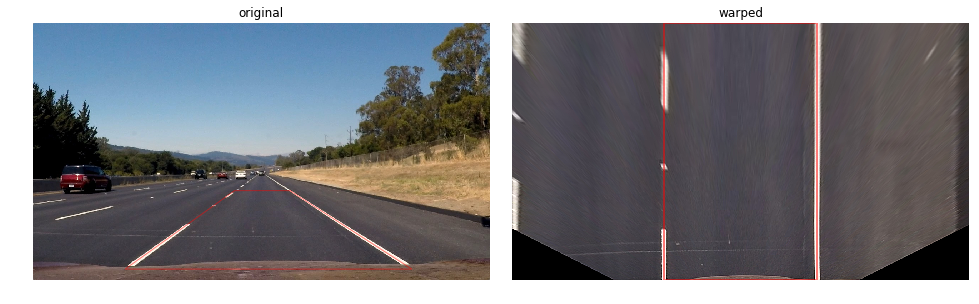

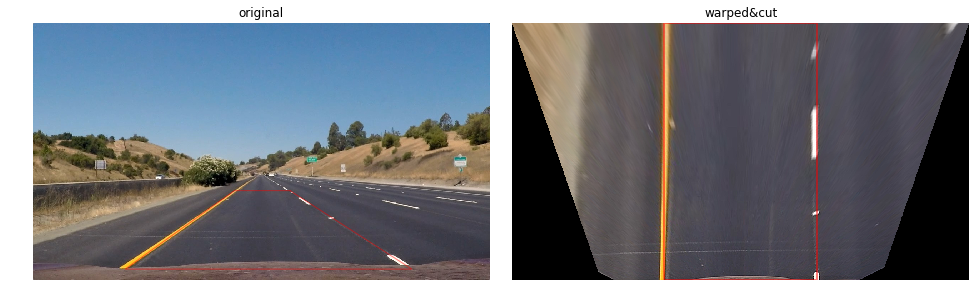

In [18]:
# Demo
if plot_demos <= 2: 
    x = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
    y = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]

    x2 = [dst[0][0],dst[1][0],dst[2][0],dst[3][0],dst[0][0]]
    y2 = [dst[0][1],dst[1][1],dst[2][1],dst[3][1],dst[0][1]]

    img = mpimg.imread('./test_images/straight_lines2.jpg')

    warped_img, M , M_inv = preprocess_img(img, mtx=mtx, dist=dist, src=src, dst=dst)

    _, ax1, ax2 = plot_two_images(img, warped_img, show = 0, titles = ['original','warped'])
    ax1.plot(x, y,'r', alpha=0.5, linewidth=1)
    ax2.plot(x2, y2,'r', alpha=0.5, linewidth=2)
    plt.savefig('./output_images/img_straight.png')


    ####
    img = mpimg.imread('./test_images/straight_lines1.jpg')

    warped_img, M , M_inv = preprocess_img(img, mtx=mtx, dist=dist, src=src, dst=dst, cut_flag = 1)


    _, ax1, ax2 = plot_two_images(img, warped_img, show = 0, titles = ['original','warped&cut'])
    ax1.plot(x, y,'r', alpha=0.5, linewidth=1)
    ax2.plot(x2, y2,'r', alpha=0.5, linewidth=2)
    plt.savefig('./output_images/img_straight2.png')
    plt.show()  

## Getting Binary

In [30]:
def colormask_treshold(img, lower, upper):
    """
    Apply a colormask on image and then return it
    """

    mask =(img[:,:,0] >= lower[0]) & (img[:,:,0] <= upper[0]) \
        & (img[:,:,1] >= lower[1]) & (img[:,:,1] <= upper[1]) \
        & (img[:,:,2] >= lower[2]) & (img[:,:,2] <= upper[2])

    return mask

def sobel_thresh(images, orient='x', ksize=11, thresh=(30, 255), boolean_op = 'and'):
    """
    Apply a sobel threshold on images, vote and then return it
    """
    if len(images.shape) <= 2:
        images = np.array([images])

    if boolean_op == 'or':
        binary_output = np.zeros_like(images[0])
    elif boolean_op == 'and':
        binary_output = np.ones_like(images[0])
    else:
        error('define boolean op in sobel tresh as ''and '' or ''or''')

    binary_output[0,0] =0

    for i, img in enumerate(images):
        if orient == 'x':
            sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=ksize)
        elif orient == 'y':
            sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=ksize)
        # 3) Take the absolute value of the derivative or gradient
        abs_sobel = np.absolute(sobel)
        # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
        # scaled_sobel = norm_0_255(sobel)
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

        # 5) Create a mask of 1's where the scaled gradient magnitude
        binary_temp = np.zeros_like(scaled_sobel)
        binary_temp[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

        if boolean_op == 'or':
            binary_output = (binary_output==1) | (binary_temp==1)
        elif boolean_op == 'and':
            binary_output = (binary_output==1) & (binary_temp==1)

    return binary_output

def adaptiveThreshold(images, block_size= 111, mean_value = 1, boolean_op = 'and'):
    """
    Apply a adaptive threshold on images, vote and then return it
    """
    if len(images.shape) <= 2:
        images = np.array([images])

    if boolean_op == 'or':
        binary_output = np.zeros_like(images[0])
    elif boolean_op == 'and':
        binary_output = np.ones_like(images[0])
    else:
        error('define boolean op in adaptiveThreshold as ''and '' or ''or''')

    binary_output[0,0] =0

    for i, img in enumerate(images):

        binary_temp = cv2.adaptiveThreshold(img,1,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,block_size,-mean_value)
        #binary_temp = cv2.adaptiveThreshold(img,1,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,block_size,mean_value)

        if boolean_op == 'or':
            binary_output = (binary_output==1) | (binary_temp==1)
        elif boolean_op == 'and':
            binary_output = (binary_output==1) & (binary_temp==1)
    # Return the binary image
    return binary_output

def blur_mask_tresh(mask, thresh = 0.8, blur_kernel = 5):
    """
    blur masks to show only regions with lots of pixels
    """
    mask = np.array(mask, dtype = 'float32')
    mask = gaussian_blur(mask, blur_kernel)
    mask[mask >= thresh] = 1
    mask[mask < 1] = 0
    mask = np.array(mask, dtype = 'uint8')
    return mask

def get_binary_img(img, plot_masks = 0, single_img = 1, line_color = 0):
    """
    Get the binary img using the methods above
    """
    ysize = img.shape[0]
    xsize = img.shape[1]

    if xsize == 0 or ysize == 0:
        combined = np.zeros_like(img[:,:,0])
        line_color = 0
    else:
        img = norm_0_255(img)
        mean_img = np.mean(img)
        #####
        hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        hls0_max = np.amax(hls_img[:,:,0])
        hls1_max  = np.amax(hls_img[:,:,1])
        hls2_max  = np.amax(hls_img[:,:,2])

        hls0_mean = np.mean(hls_img[:,:,0])
        hls1_mean  = np.mean(hls_img[:,:,1])
        hls2_mean  = np.mean(hls_img[:,:,2])

        hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        hsv0_max = np.amax(hsv_img[:,:,0])
        hsv1_max = np.amax(hsv_img[:,:,1])
        hsv2_max = np.amax(hsv_img[:,:,2])

        hsv0_mean = np.mean(hsv_img[:,:,0])
        hsv1_mean = np.mean(hsv_img[:,:,1])
        hsv2_mean = np.mean(hsv_img[:,:,2])

        lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        lab0_max = np.amax(lab_img[:,:,0])
        lab1_max = np.amax(lab_img[:,:,1])
        lab2_max = np.amax(lab_img[:,:,2])

        lab0_mean = np.mean(lab_img[:,:,0])
        lab1_mean = np.mean(lab_img[:,:,1])
        lab2_mean = np.mean(lab_img[:,:,2])

        red_max = np.amax(img[:,:,0])
        red_mean = np.mean(img[:,:,0])
        #####
        vertices = np.array([(320, 0),
                             (960, 0),
                             (960, 720),
                             (320,720)])

        if line_color == 0 or line_color == 1:
            gradx_wht = np.asarray(sobel_thresh(np.array([img[:,:,0], hsv_img[:,:,2]]),
                                                orient='x',
                                                ksize = 15,
                                                thresh=(28, 255),
                                                boolean_op = 'and'), dtype='uint8')
        if line_color == 0 or line_color == 2:
            gradx_yel = np.asarray(sobel_thresh(np.array([hls_img[:,:,2], lab_img[:,:,2]]),
                                                orient='x',
                                                ksize = 15,
                                                thresh=(20, 255),
                                                boolean_op = 'and'), dtype='uint8')
        if line_color == 0:
            gradx = gradx_wht | gradx_yel
        elif line_color == 1: 
            gradx = gradx_wht
        elif line_color == 2: 
            gradx = gradx_yel 

        if line_color == 0 or line_color == 1:
            adap_mask_wht = np.asarray(adaptiveThreshold(np.array([img[:,:,0], hsv_img[:,:,2]]),
                                                         block_size= 161,
                                                         mean_value = 33,
                                                         boolean_op = 'and'), dtype='uint8')
        if line_color == 0 or line_color == 2:
            adap_mask_yel = np.asarray(adaptiveThreshold(np.array([hls_img[:,:,2], lab_img[:,:,2]]),
                                                         block_size= 161, mean_value = 5,
                                                         boolean_op = 'and'), dtype='uint8')
        if line_color == 0:        
            adap_mask =  adap_mask_yel | adap_mask_wht
        elif line_color == 1:    
            adap_mask =  adap_mask_wht
        elif line_color == 2:    
            adap_mask =  adap_mask_yel    

        if single_img:
            gradx = region_of_interest(gradx, vertices)
            adap_mask = region_of_interest(adap_mask, vertices)  
            img[:,:,0] = region_of_interest(img[:,:,0], vertices)

        #####
        # Threshold image to get only yellow/white
        ### H L S
        hls_wht = np.zeros_like(img[:,:,0])
        hls_yel = np.zeros_like(img[:,:,0])

        if line_color == 0 or line_color == 1:
            adap =  max(160, int(hls1_max *0.90),int(hls1_mean * 1.4))
            lower_wht = np.array((0, adap,  0))
            upper_wht = np.array((255, 255, 255))

            hls_wht = colormask_treshold(hls_img, lower_wht,upper_wht)

        if line_color == 0 or line_color == 2:   
            adap =  max(int(hls2_max *0.25),int(hls2_mean *1.75))
            adap2 = max(80, int(hls1_mean * 1.35))
            lower_yel = np.array((15,adap2,adap))
            upper_yel = np.array((30,255,255))

            hls_yel = colormask_treshold(hls_img, lower_yel,upper_yel)

        if line_color == 0:        
            hls_mask =  np.asarray(hls_yel | hls_wht, dtype='uint8')
        elif line_color == 1:    
            hls_mask =  np.asarray(hls_wht, dtype='uint8')
        elif line_color == 2:    
            hls_mask =  np.asarray(hls_yel, dtype='uint8')   

        ### L A B
        lab_wht = np.zeros_like(img[:,:,0])
        lab_yel = np.zeros_like(img[:,:,0])
        if line_color == 0 or line_color == 1:
            adap = max(160, int(lab0_max *0.90),int(lab0_mean * 1.1))
            lower_wht = np.array((adap, 125, 120))
            upper_wht = np.array((255, 140, 155))

            lab_wht = colormask_treshold(lab_img, lower_wht,upper_wht)  

        if line_color == 0 or line_color == 2:  
            adap1 =  max(int(lab2_max *0.75), int(lab2_mean * 1.2))
            adap2 = max(80, int(lab0_max * 0.5))
            lower_yel = np.array((adap2, 120, adap1))
            upper_yel = np.array((255,145,255))

            lab_yel = colormask_treshold(lab_img, lower_yel,upper_yel)

        if line_color == 0:        
            lab_mask =  np.asarray(lab_yel | lab_wht, dtype='uint8')
        elif line_color == 1:    
            lab_mask =  np.asarray(lab_wht, dtype='uint8')
        elif line_color == 2:    
            lab_mask =  np.asarray(lab_yel, dtype='uint8')  

        ### H S V
        hsv_wht = np.zeros_like(img[:,:,0])
        hsv_yel = np.zeros_like(img[:,:,0])
        if line_color == 0 or line_color == 1:
            adap =  max(150, int(hsv2_max *0.90),int(hsv2_mean * 1.4))
            lower_wht = np.array((0, 0, adap))
            upper_wht = np.array((255,40,255))

            hsv_wht = colormask_treshold(hsv_img, lower_wht,upper_wht)

        if line_color == 0 or line_color == 2:
            adap =  max(int(hsv1_max *0.25), int(hsv1_mean * 1.75))
            adap2 =  max(50, int(hsv2_mean * 1.5))
            lower_yel = np.array((15,adap,adap2))
            upper_yel = np.array((30,255,255))

            hsv_yel = colormask_treshold(hsv_img, lower_yel,upper_yel)    

        if line_color == 0:        
            hsv_mask =  np.asarray(hsv_yel | hsv_wht, dtype='uint8')
        elif line_color == 1:    
            hsv_mask =  np.asarray(hsv_wht, dtype='uint8')
        elif line_color == 2:    
            hsv_mask =  np.asarray(hsv_yel, dtype='uint8')  
        ### RED
        adap = min(max(150, int(red_max * 0.6), int(red_mean * 1.95)),230)
        lower_red = np.array((adap, 0, 0))
        upper_red = np.array((255,255,255))

        red_mask = colormask_treshold(img, lower_red, upper_red)
        red_mask = np.asarray(red_mask, dtype='uint8')

        # get the color of the line, 0 = no color, 1 = white, 2 = yellow, decide on number of pixels
        if not single_img and line_color == 0 :
            if np.sum(hsv_yel + hls_yel + lab_yel + adap_mask_yel) > np.sum(hsv_wht + hls_wht + lab_wht + adap_mask_wht):
                line_color = 2
            else:
                line_color = 1
        ####### Combine

        if single_img:
            combined = np.asarray(red_mask*2 + hsv_mask + lab_mask + hls_mask + gradx*3 + adap_mask*3, dtype='uint8')
        else:
            combined = np.asarray(red_mask + hsv_mask + lab_mask + hls_mask + gradx + adap_mask*2, dtype='uint8')
        combined[combined<3] = 0
        combined[combined>=3] = 1

        combined = blur_mask_tresh(combined, thresh = 0.9, blur_kernel = 7)

        if plot_masks:

            plt.figure(figsize=(13,5))
            plt.subplots_adjust(top=1.0,bottom=0.0,left=0.0,right=1.0,hspace=0.1,wspace=0.05)

            plt.subplot(2,3,1)
            plt.imshow(hls_img[:,:,0], cmap='inferno')
            plt.title('hls_img[:,:,0]')
            plt.axis('off')

            plt.subplot(2,3,2)
            plt.imshow(hls_img[:,:,1], cmap='inferno')
            plt.title('hls_img[:,:,1]')
            plt.axis('off')

            plt.subplot(2,3,3)
            plt.imshow(hls_img[:,:,2], cmap='inferno')
            plt.title('hls_img[:,:,2]')
            plt.axis('off')

            plt.subplot(2,3,4)
            plt.imshow(hls_wht, cmap='inferno')
            plt.title('hls_wht')
            plt.axis('off')

            plt.subplot(2,3,5)
            plt.imshow(hls_yel, cmap='inferno')
            plt.title('hls_yel')
            plt.axis('off')

            plt.subplot(2,3,6)
            plt.imshow(hls_mask, cmap='inferno')
            plt.title('hls_mask')
            plt.axis('off')
            plt.savefig('./output_images/hls_mask.png')
            
            plt.figure(figsize=(13,5))
            plt.subplots_adjust(top=1.0,bottom=0.0,left=0.0,right=1.0,hspace=0.1,wspace=0.05)
            plt.subplot(2,3,1)
            plt.imshow(lab_img[:,:,0], cmap='inferno')
            plt.title('lab_img[:,:,0]')
            plt.axis('off')

            plt.subplot(2,3,2)
            plt.imshow(lab_img[:,:,1], cmap='inferno')
            plt.title('lab_img[:,:,1]')
            plt.axis('off')

            plt.subplot(2,3,3)
            plt.imshow(lab_img[:,:,2], cmap='inferno')
            plt.title('lab_img[:,:,2]')
            plt.axis('off')

            plt.subplot(2,3,4)
            plt.imshow(lab_wht, cmap='inferno')
            plt.title('lab_wht')
            plt.axis('off')

            plt.subplot(2,3,5)
            plt.imshow(lab_yel, cmap='inferno')
            plt.title('lab_yel')
            plt.axis('off')

            plt.subplot(2,3,6)
            plt.imshow(lab_mask, cmap='inferno')
            plt.title('lab_mask')
            plt.axis('off')
            plt.savefig('./output_images/lab_mask.png')
            
            plt.figure(figsize=(13,5))
            plt.subplots_adjust(top=1.0,bottom=0.0,left=0.0,right=1.0,hspace=0.1,wspace=0.05)
            plt.subplot(2,3,1)
            plt.imshow(hsv_img[:,:,0], cmap='inferno')
            plt.title('hsv_img[:,:,0]')
            plt.axis('off')

            plt.subplot(2,3,2)
            plt.imshow(hsv_img[:,:,1], cmap='inferno')
            plt.title('hsv_img[:,:,1]')
            plt.axis('off')

            plt.subplot(2,3,3)
            plt.imshow(hsv_img[:,:,2], cmap='inferno')
            plt.title('hsv_img[:,:,2]')
            plt.axis('off')

            plt.subplot(2,3,4)
            plt.imshow(hsv_wht, cmap='inferno')
            plt.title('hsv_wht')
            plt.axis('off')

            plt.subplot(2,3,5)
            plt.imshow(hsv_yel, cmap='inferno')
            plt.title('hsv_yel')
            plt.axis('off')

            plt.subplot(2,3,6)
            plt.imshow(hsv_mask, cmap='inferno')
            plt.title('hsv_mask')
            plt.axis('off')
            plt.savefig('./output_images/hsv_mask.png')
            
            plt.figure(figsize=(13,5))
            plt.subplots_adjust(top=1.0,bottom=0.0,left=0.0,right=1.0,hspace=0.1,wspace=0.05)
            plt.subplot(1,3,1)
            plt.imshow(img[:,:,0], cmap='inferno')
            plt.title('red_img')
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.imshow(red_mask, cmap='inferno')
            plt.title('red_mask')
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.imshow(adap_mask, cmap='inferno')
            plt.title('adap_mask')
            plt.axis('off')
            plt.savefig('./output_images/red_and_adap_mask.png')
            
            plt.figure(figsize=(13,5))
            plt.subplots_adjust(top=1.0,bottom=0.0,left=0.0,right=1.0,hspace=0.1,wspace=0.05)

            plt.subplot(1,3,1)
            plt.imshow(img, cmap='inferno')
            plt.title('img transformed')
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.imshow(combined, cmap='inferno')
            plt.title('all masks combined')
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.imshow(gradx, cmap='inferno')
            plt.title('gradx')
            plt.axis('off')
            
            plt.savefig('./output_images/all_combined.png')
            
            plt.show()
            #########  
    if single_img:
        return combined
    else: 
        return  combined, line_color

 
 ----NEW IMAGE----


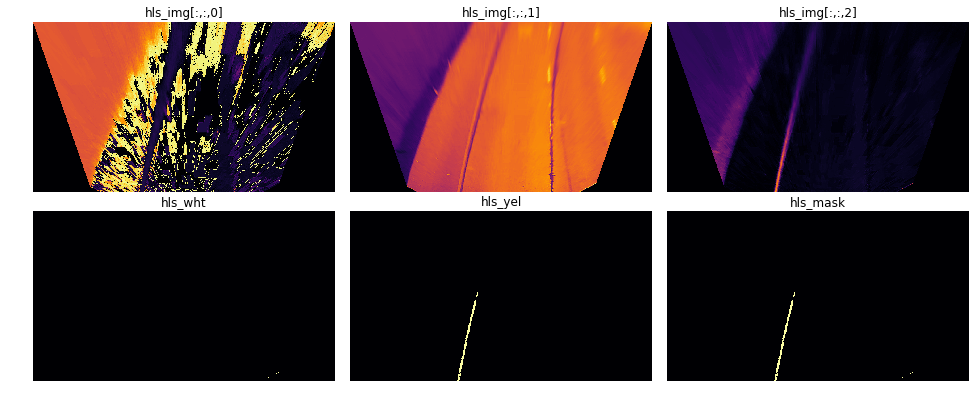

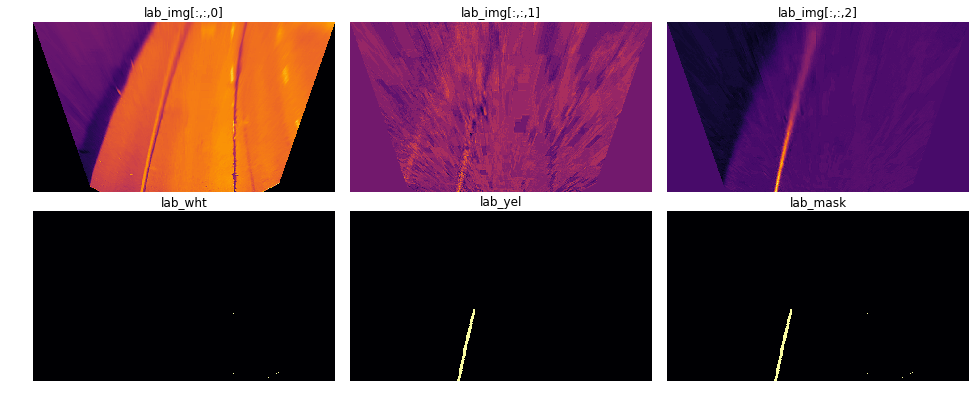

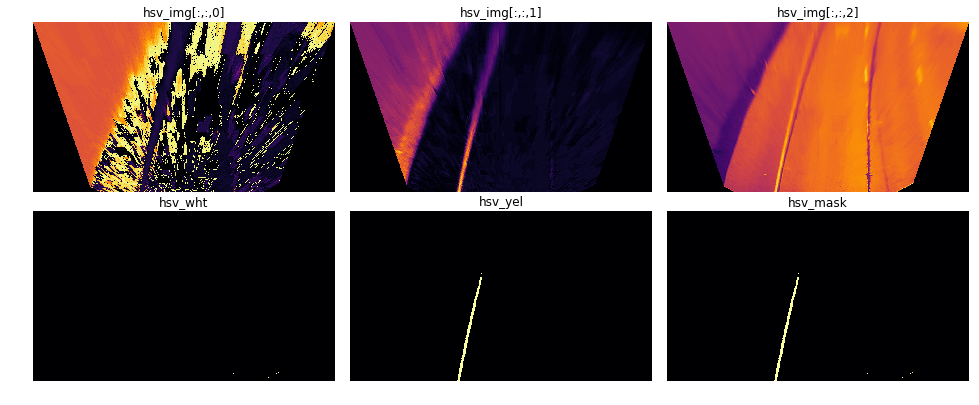

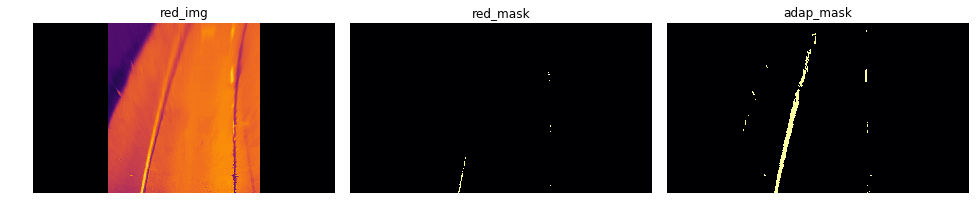

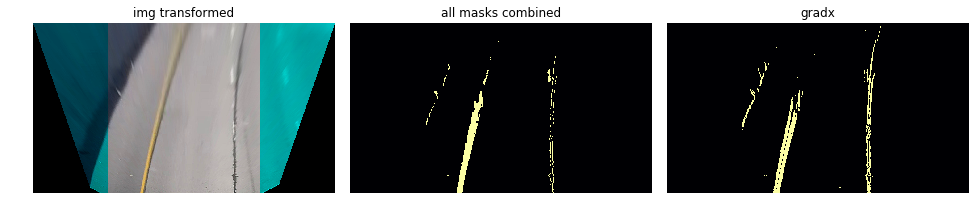

result:


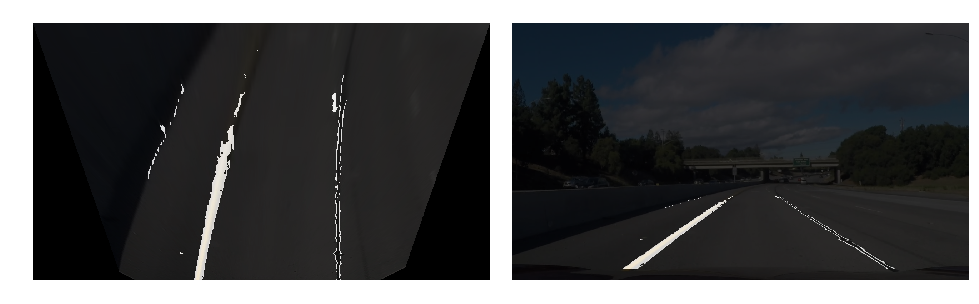

 
 
 
 
 ----NEW IMAGE----


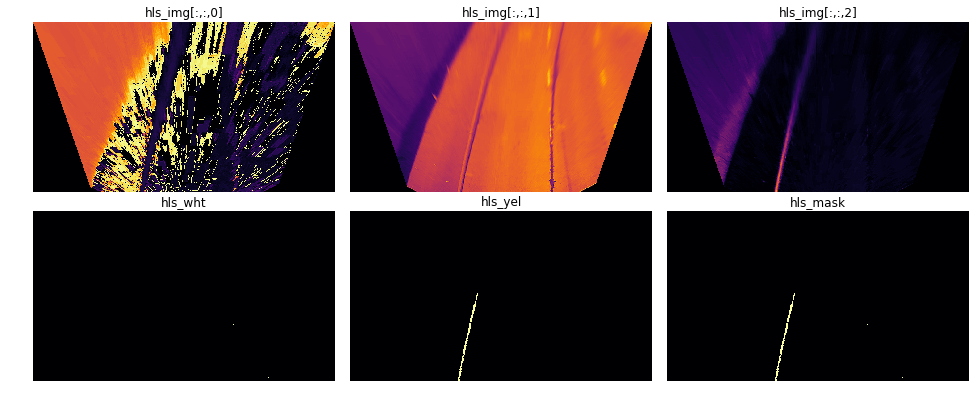

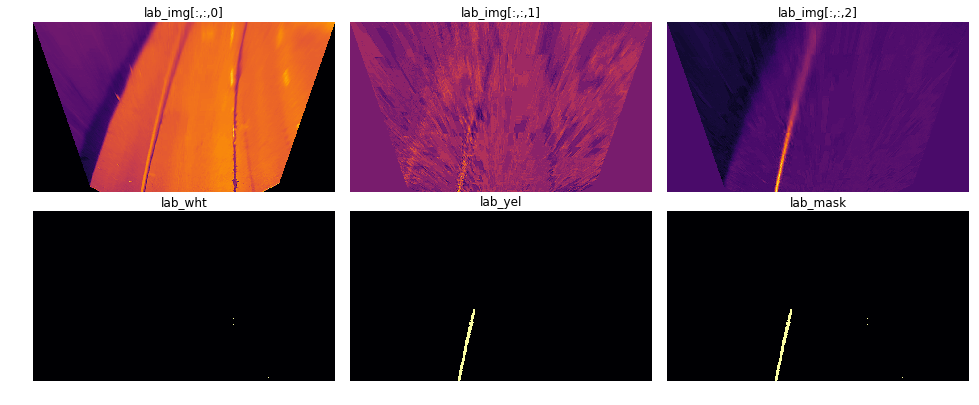

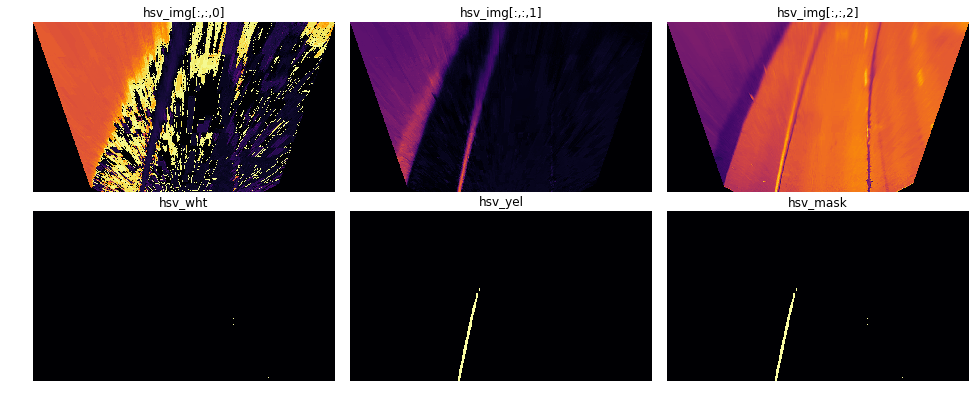

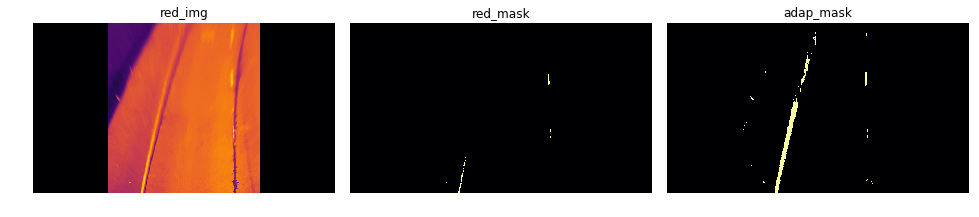

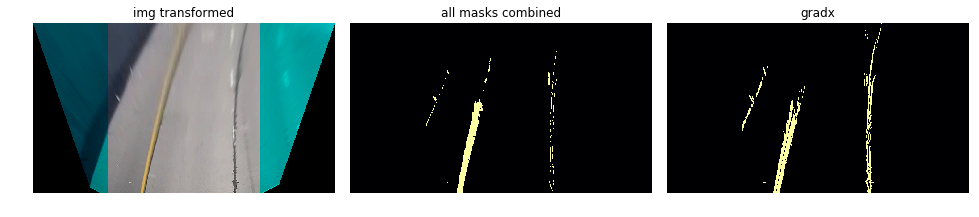

result:


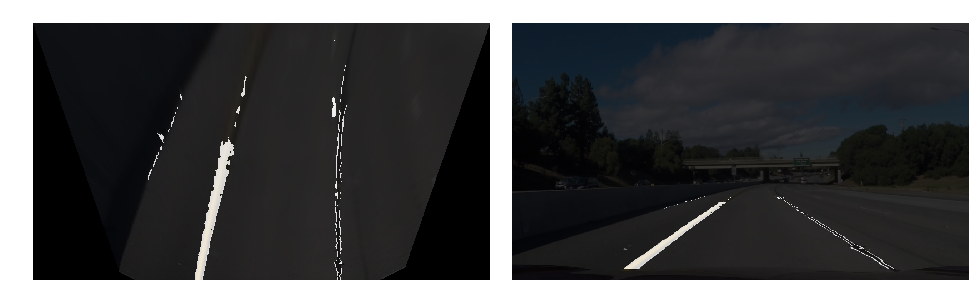

 
 
 
 
 ----NEW IMAGE----


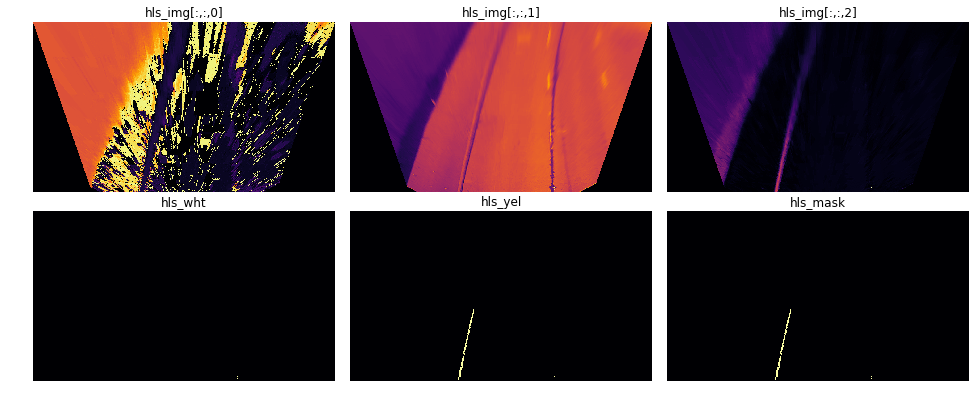

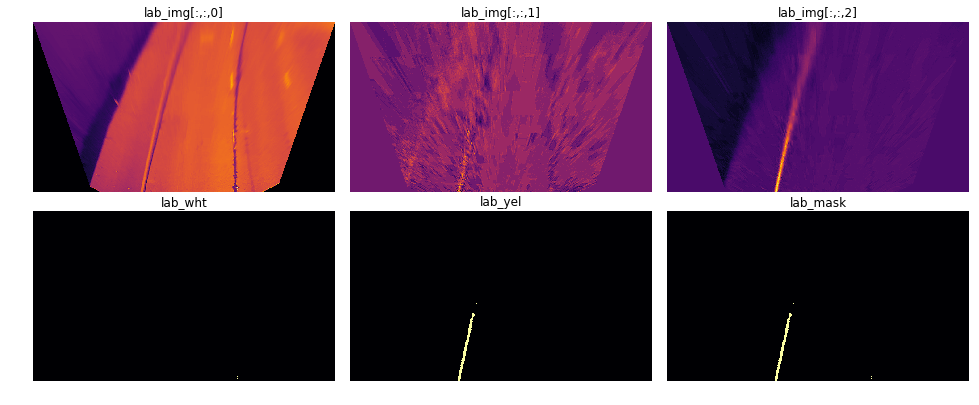

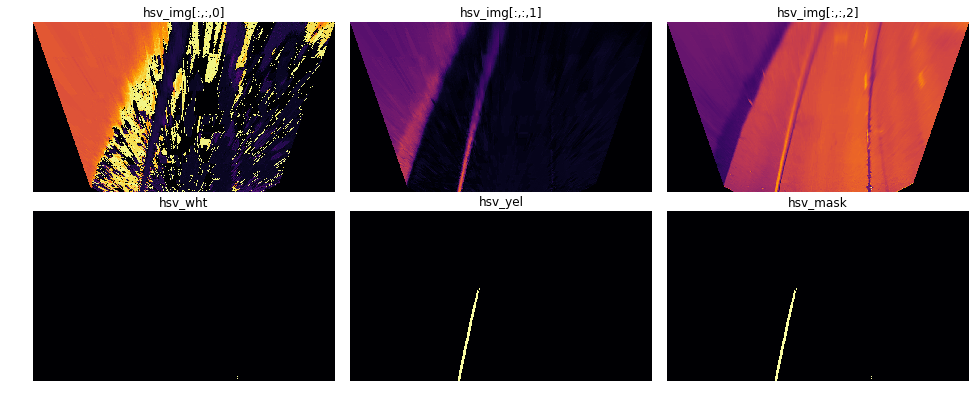

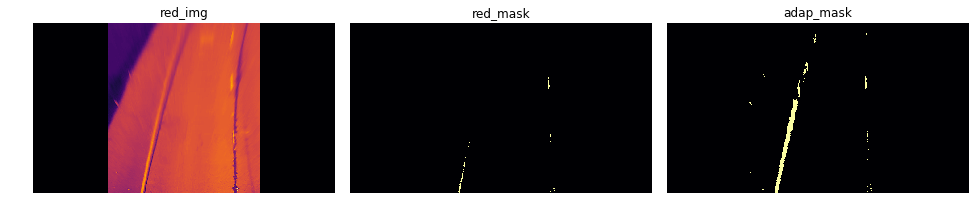

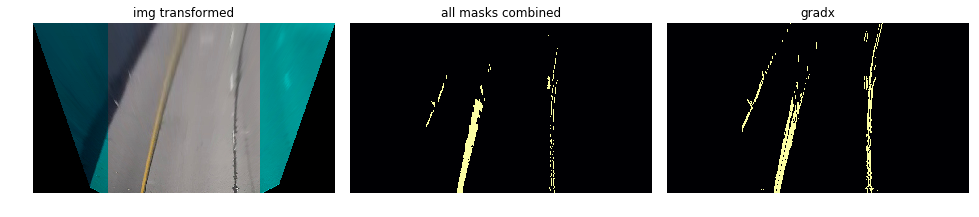

result:


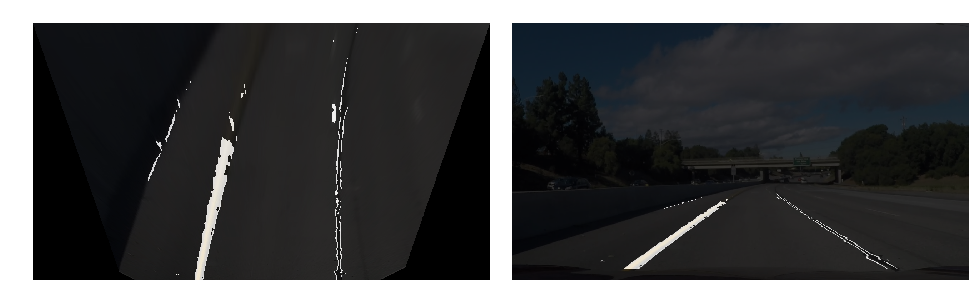

In [31]:
# Demo

if plot_demos <=3: 
    # Make a list of test images
    images = glob.glob('./video_images/*.jpg')
    images = sort_nicely(images)
    for img_name in images[1269:1272]:
        img = mpimg.imread(img_name)

        warped_img, M , M_inv = preprocess_img(img, mtx=mtx, dist=dist, src=src, dst=dst,cut_flag= 1)
        print(' \n ----NEW IMAGE----')
        binary_img = get_binary_img(warped_img, plot_masks = 1)

        binary_img = norm_0_255(binary_img)
        binary_img = np.dstack((binary_img, binary_img, binary_img))

        img2 = weighted_img(binary_img, 0.75, warped_img,0.25)    
        print('result:')
        binary_img, M, M_inv = warp_img(binary_img, w_Mat = M_inv)     
        img = weighted_img(binary_img, 0.75, img,0.25)
        #print(img_name)

        plot_two_images(img2, img)
        plt.savefig('./output_images/result.png')
        print(' \n \n ')


## Getting Lane Lines: Polyfit using sliding window

In [21]:
def gen_poly_data(poly_para,y):
    left_fit = poly_para[0]
    right_fit = poly_para[1]
    
    left_fitx = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    right_fitx = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
    return left_fitx, right_fitx

def gen_poly_derivat_data(poly_para,y):
    left_fit = poly_para[0]
    right_fit = poly_para[1]
    
    left_fitx = 2*left_fit[0]*y + left_fit[1] 
    right_fitx = 2*right_fit[0]*y + right_fit[1]
    return left_fitx, right_fitx

def polyfit_sliding_win(img):
    assert len(img.shape) == 2
    
    ysize = img.shape[0]
    xsize = img.shape[1]
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 75
    # Set minimum number of pixels found to recenter window
    minpix = 45
    # Set height of windows
    window_height = np.int(ysize/nwindows)         
    out_img = np.dstack((img, img, img))*255

    histogram = np.sum(img[int(ysize/2):,:], axis=0)
    midpoint = np.int(xsize/2)

    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = ysize - (window+1)*window_height
        win_y_high = ysize - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &\
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &\
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    poly_para = np.array([left_fit,right_fit])

    ploty = np.linspace(0, ysize-1, ysize)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    poly_data = np.array([left_fitx,right_fitx,ploty])

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 50, 50]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [50, 50, 255]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])

    cv2.polylines(out_img, np.int32([pts_left]), isClosed=False, color=(240,240,240), thickness=4)
    cv2.polylines(out_img, np.int32([pts_right]), isClosed=False, color=(240,240,240), thickness=4)

    out_img = norm_0_1(out_img)
        
    return out_img, histogram, poly_para, poly_data


[ -3.34968722e-05   7.99021326e-03   4.30887900e+02]
[  2.57271313e-05  -1.31078322e-02   8.48834544e+02]


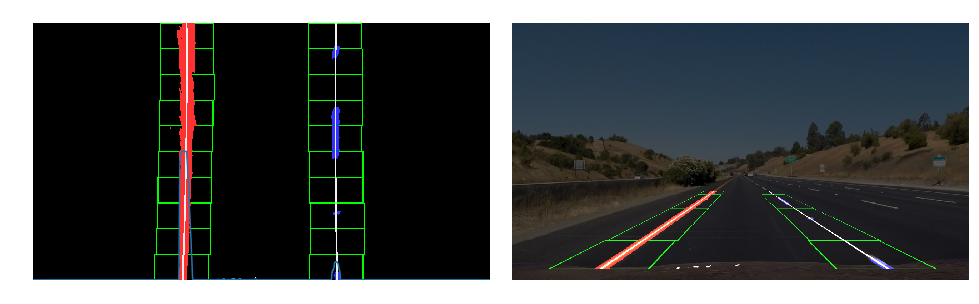

[ -1.91199063e-06  -1.22054008e-03   4.27556951e+02]
[  1.95575433e-06  -6.46963054e-03   8.56829590e+02]


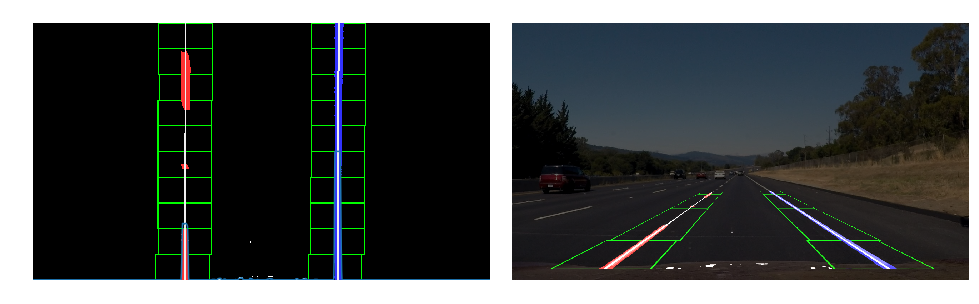

[  8.04768008e-05  -1.03935224e-01   4.71793059e+02]
[  7.68967864e-05  -1.12117640e-01   9.17679554e+02]


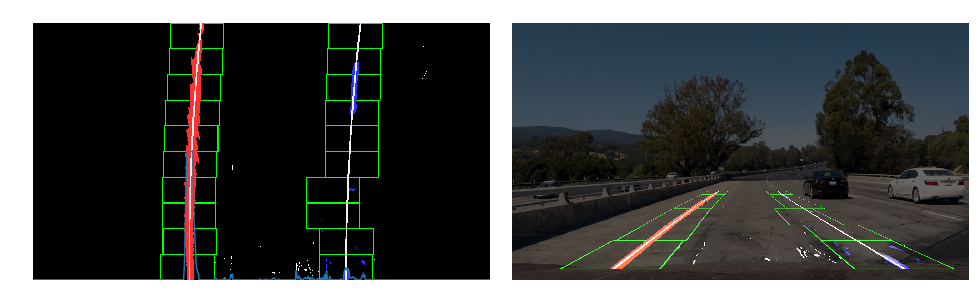

[ -8.38120858e-05   1.07517882e-01   4.26397706e+02]
[ -1.52311269e-04   1.60091486e-01   8.39728882e+02]


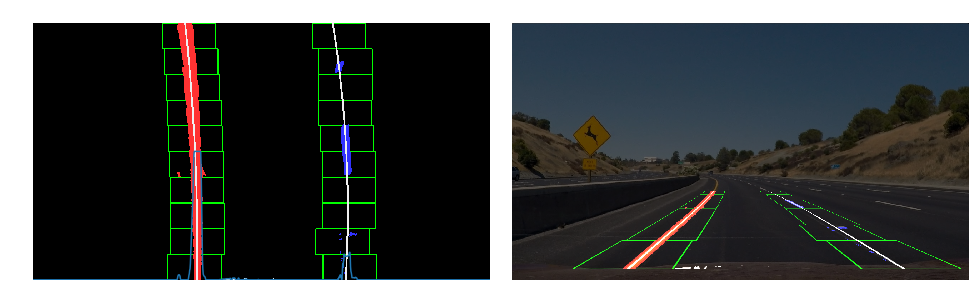

[  2.35377810e-05  -1.20107259e-01   5.06131780e+02]
[  6.73218752e-05  -1.12194727e-01   9.17519032e+02]


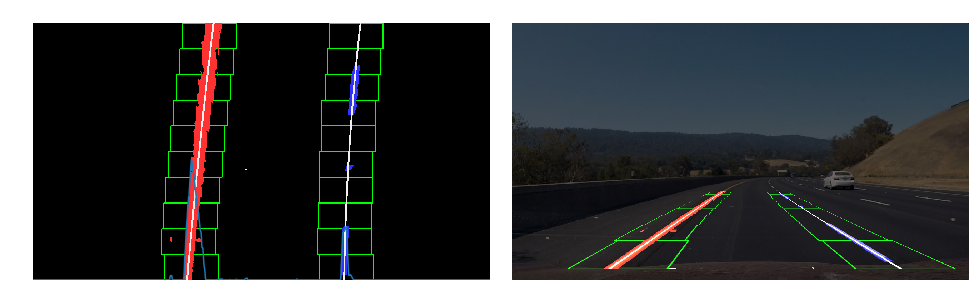

[  2.02472131e-05  -4.41068474e-02   4.69808626e+02]
[  2.37037433e-04  -2.10317370e-01   9.36632809e+02]


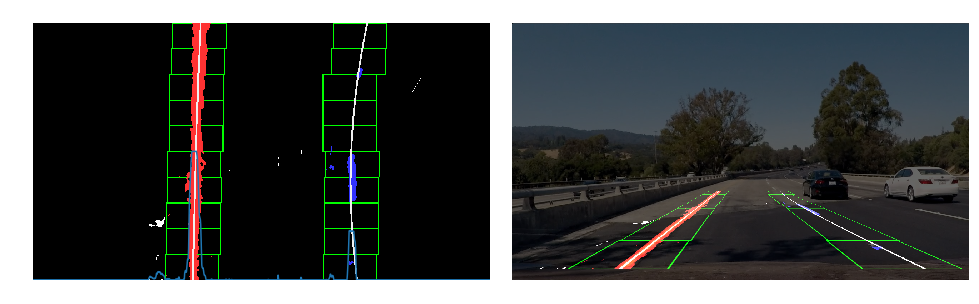

[  9.53573651e-05  -1.37701659e-01   4.53397775e+02]
[  2.35157547e-04  -2.05252424e-01   9.19178741e+02]


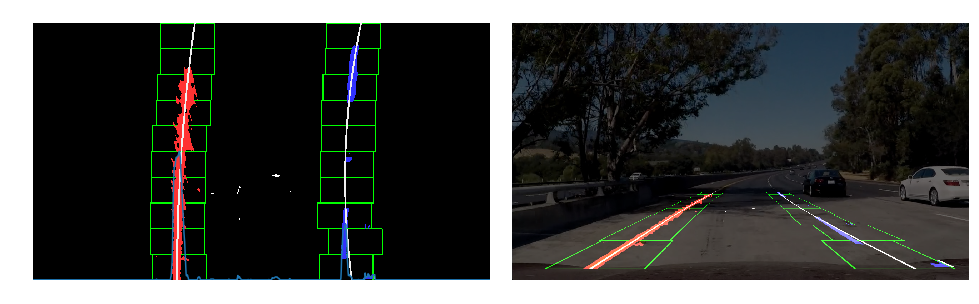

[  5.50282984e-05  -1.45923741e-01   5.21722225e+02]
[ -4.42127667e-07  -6.92294304e-02   9.32160536e+02]


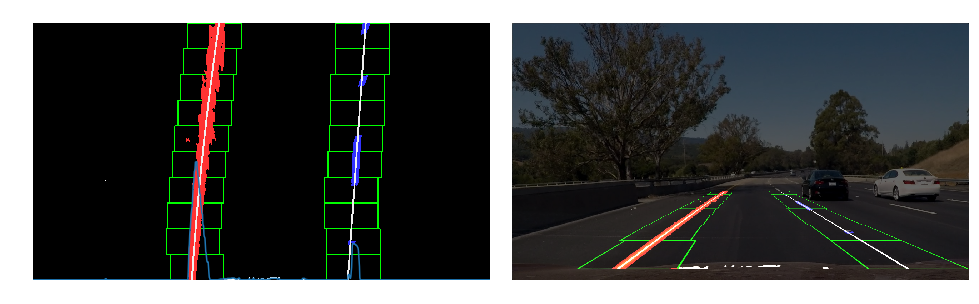

In [22]:
# Demo
if plot_demos <= 4:
    # Make a list of test images
    images = glob.glob('./test_images/*.jpg')

    for i, img_name in enumerate(images):

        img = mpimg.imread(img_name)

        warped_img, M , M_inv = preprocess_img(img, mtx=mtx, dist=dist, src=src, dst=dst,cut_flag = 1)

        binary_img = get_binary_img(warped_img)

        poly_img, histogram, poly_para, poly_data = polyfit_sliding_win(binary_img)

        left_fit = poly_para[0]
        right_fit = poly_para[1]
        left_fitx = poly_data[0]
        right_fitx = poly_data[1]
        ploty = poly_data[2]

        #print(img_name)
        print(left_fit)
        print(right_fit)

        poly_img2 = norm_0_255(poly_img)

        poly_img2, M, M_inv = warp_img(poly_img2, w_Mat = M_inv)
        img = weighted_img(poly_img2, 1, img,0.4)

        _, ax1, ax2 = plot_two_images(poly_img, img, show = 0)
        ax1.plot(-histogram + ysize)
        plt.show()

## Getting Lane Lines: Polyfit using previous fit search window

In [23]:
 def polyfit_search_win(img, poly_para, poly_data, debug_plot = 0, plot_win_masks = 0, line_colors = [0,0], return_line_colors = 0):
    assert len(img.shape) == 3 # check if 3 dimensional array
    global poly_arr

    ysize = img.shape[0]
    xsize = img.shape[1]
    old_left_fit = poly_para[0]
    old_right_fit = poly_para[1]
    old_left_fitx = poly_data[0]
    old_right_fitx = poly_data[1]
    ploty = poly_data[2]

    # Set the width of the windows +/- margin
    bin_win_margin = 75
    margin = 60

    # Choose the number of windows
    nwindows = 10

    # Set height of windows
    window_height = np.int(ysize/nwindows)

    # create empty binary
    binary_img = np.zeros_like(img[:,:,0])
    plot_img = img.copy()

    # Current positions to be updated for each window
    leftx_current = int(old_left_fitx[-1:])
    rightx_current = int(old_right_fitx[-1:])
    #print("warped_img shape :", img.shape)
    # Step through the windows one by one
    if sum(line_colors) <= 1:
        color_left = 0
        color_right = 0
        count_color_left = 0
        count_color_right = 0
    else:
        color_left = line_colors[0]
        color_right = line_colors[1]
        count_color_left = 0
        count_color_right = 0
        
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = ysize - (window+1)*window_height
        win_y_high = ysize - window*window_height
        win_xleft_low = min(1280, max(0, leftx_current - bin_win_margin))
        win_xleft_high = min(1280, max(0, leftx_current + bin_win_margin))
        win_xright_low = min(1280, max(0, rightx_current - bin_win_margin))
        win_xright_high = min(1280, max(0, rightx_current + bin_win_margin))
#         print('y low', win_y_low, 'y high', win_y_high)
#         print('x left low', win_xleft_low, '| x left high', win_xleft_high, '| x right low', win_xright_low, '| x right high', win_xright_high)
        win_img_left = img[win_y_low:win_y_high, win_xleft_low:win_xleft_high,:]
        binary_img[win_y_low:win_y_high, win_xleft_low:win_xleft_high], left_line_color = get_binary_img(win_img_left, plot_masks = plot_win_masks, single_img = 0, line_color = color_left)
    
        win_img_right = img[win_y_low:win_y_high, win_xright_low:win_xright_high,:]
        binary_img[win_y_low:win_y_high, win_xright_low:win_xright_high], right_line_color = get_binary_img(win_img_right, plot_masks = plot_win_masks, single_img = 0, line_color = color_right)
#         print('left color', left_line_color, ' | right color', right_line_color)
        if sum(line_colors) <= 1:
            if left_line_color == 1:
                count_color_left +=  1
            elif left_line_color == 2:
                count_color_left -=  1

            if count_color_left >= 3:
                color_left = 1
            elif count_color_left <= -3:
                color_left = 2

            if right_line_color == 1:
                count_color_right +=  1
            elif right_line_color == 2:
                count_color_right -=  1

            if count_color_right >= 3:
                color_right = 1
            elif count_color_right <= -3:
                color_right = 2      
            
        #print("win_img_left, win_img_right shape :", win_img_left.shape, win_img_right.shape )
        leftx_current = int(old_left_fitx[win_y_low])
        rightx_current = int(old_right_fitx[win_y_low])

        if debug_plot:

            # Recast the x and y points into usable format for cv2.fillPoly()
            pts_left = np.array([np.transpose(np.vstack([old_left_fitx, ploty]))])
            pts_right = np.array([np.flipud(np.transpose(np.vstack([old_right_fitx, ploty])))])

            cv2.polylines(plot_img, np.int32([pts_left]), isClosed=False, color=(240,0,240), thickness=4)
            cv2.polylines(plot_img, np.int32([pts_right]), isClosed=False, color=(240,0,240), thickness=4)

            bin_win_left_plot = binary_img[win_y_low:win_y_high, win_xleft_low:win_xleft_high]
            bin_win_left_plot = np.dstack((bin_win_left_plot, np.zeros_like(bin_win_left_plot), np.zeros_like(bin_win_left_plot)))*255

            bin_win_right_plot = binary_img[win_y_low:win_y_high, win_xright_low:win_xright_high]
            bin_win_right_plot = np.dstack((np.zeros_like(bin_win_right_plot), np.zeros_like(bin_win_right_plot), bin_win_right_plot))*255

            plot_win_left = out_img = weighted_img(bin_win_left_plot, 0.5, win_img_left,0.7)
            plot_win_right = out_img = weighted_img(bin_win_right_plot, 0.5, win_img_right,0.7)

            cv2.rectangle(plot_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5)
            cv2.rectangle(plot_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5)

            f = plt.figure(figsize=(13,5))

            plt.subplot(2,2,1)
            plt.axis('off')
            plt.imshow(binary_img, cmap='inferno')

            plt.subplot(2,2,2)
            plt.axis('off')
            plt.imshow(plot_img, cmap='inferno')

            plt.subplot(2,2,3)
            plt.axis('off')
            plt.imshow(plot_win_left, cmap='inferno')
            plt.title('left lane')

            plt.subplot(2,2,4)
            plt.axis('off')
            plt.imshow(plot_win_right, cmap='inferno')
            plt.title('right lane')

            plt.subplots_adjust(top=0.98,bottom=0.0,left=0.0,right=1.0,hspace=0.1,wspace=0.05)
            plt.savefig('./gif_images/process_{}.png'.format(window))
            plt.show()

            plot_img[win_y_low:win_y_high, win_xleft_low:win_xleft_high] = plot_win_left
            plot_img[win_y_low:win_y_high, win_xright_low:win_xright_high] = plot_win_right
            
    line_colors = [color_left, color_right]
    
    #binary_img = refill_img(binary_img, 1280, 720)
    out_img = np.dstack((binary_img, binary_img, binary_img))*255

    window_img = np.zeros_like(out_img)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (old_left_fit[0]*(nonzeroy**2) + old_left_fit[1]*nonzeroy + old_left_fit[2] - margin)) \
                            & (nonzerox < (old_left_fit[0]*(nonzeroy**2) + old_left_fit[1]*nonzeroy + old_left_fit[2] + margin)))

    right_lane_inds = ((nonzerox > (old_right_fit[0]*(nonzeroy**2) + old_right_fit[1]*nonzeroy + old_right_fit[2] - margin))\
                           & (nonzerox < (old_right_fit[0]*(nonzeroy**2) + old_right_fit[1]*nonzeroy + old_right_fit[2] + margin)))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    #### Sanity Check

    if len(leftx) != 0:
        new_left_fit = np.polyfit(lefty, leftx, 2)
    else:
        new_left_fit = old_left_fit

    if len(rightx) != 0:
        new_right_fit = np.polyfit(righty, rightx, 2)
    else:
        new_right_fit = old_right_fit
        
    #### SMOOTHING
    new_poly_para = np.array([new_left_fit,new_right_fit])

    new_left_fitx = new_left_fit[0]*ploty**2 + new_left_fit[1]*ploty + new_left_fit[2]
    new_right_fitx = new_right_fit[0]*ploty**2 + new_right_fit[1]*ploty + new_right_fit[2]

    new_poly_data = np.array([new_left_fitx,new_right_fitx])
    if len(poly_arr) == 0:
        #print("poly data array empty")
        poly_arr = np.array([poly_data[0:2]])
        poly_arr = np.concatenate((poly_arr, [new_poly_data]), axis=0)
    elif len(poly_arr) < 5:
        poly_arr = np.concatenate((poly_arr, [new_poly_data]), axis=0)
    else:
        poly_arr[:-1] = poly_arr[1:]
        poly_arr[-1:] = new_poly_data

    for i in range(len(ploty)):
        new_left_fitx[i] = np.mean(poly_arr[:,0,i])
        new_right_fitx[i] = np.mean(poly_arr[:,1,i])

    new_poly_data = np.array([new_left_fitx, new_right_fitx, ploty])

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 50, 50]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [50, 50, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([new_left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([new_left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))

    right_line_window1 = np.array([np.transpose(np.vstack([new_right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([new_right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

    out_img = weighted_img(out_img, 1, window_img,0.3)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([new_left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([new_right_fitx, ploty])))])

    cv2.polylines(out_img, np.int32([pts_left]), isClosed=False, color=(240,240,240), thickness=4)
    cv2.polylines(out_img, np.int32([pts_right]), isClosed=False, color=(240,240,240), thickness=4)

    out_img = norm_0_1(out_img)
    if return_line_colors:
        return out_img, new_poly_para, new_poly_data, line_colors
    
    return out_img, new_poly_para, new_poly_data

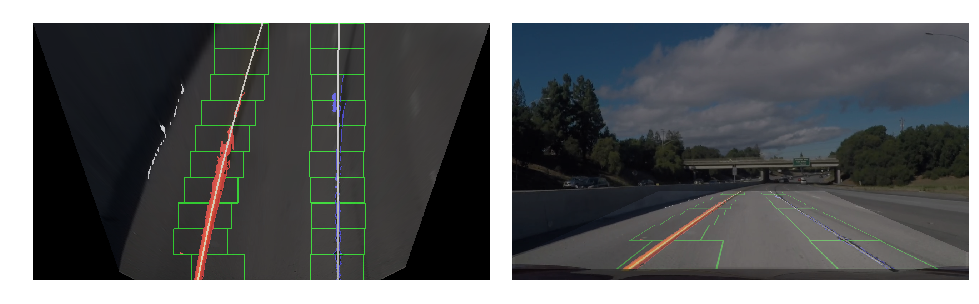

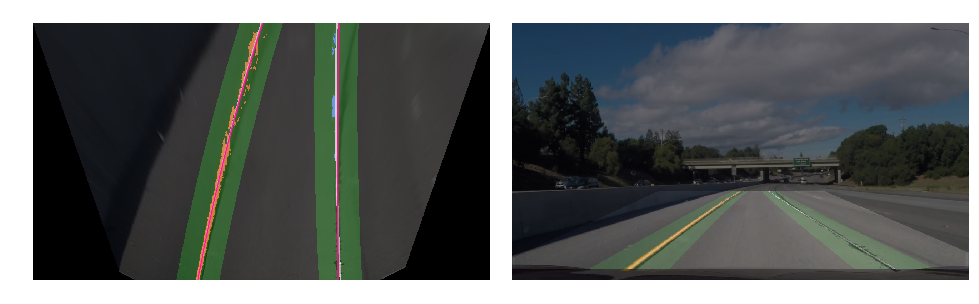

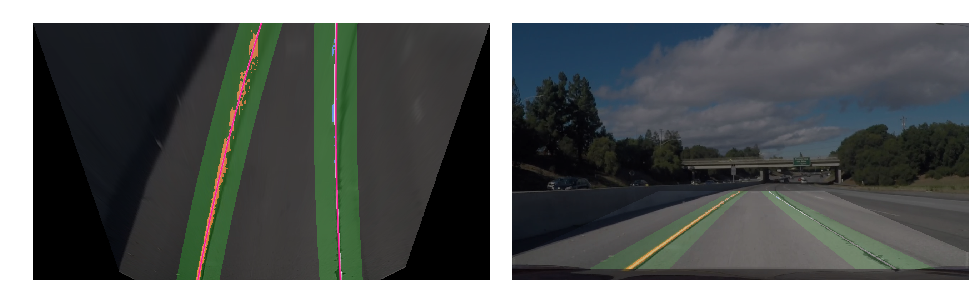

In [24]:
# Initialization
poly_arr = np.array([])

# Demo 
if plot_demos <= 5:
    # Make a list of test images
    images = glob.glob('./video_images/*.jpg')
    images = sort_nicely(images)

    for i,img_name in enumerate(images[1269:1272]):
#         print(img_name)
        img = mpimg.imread(img_name)

        warped_img, M , M_inv = preprocess_img(img, mtx=mtx, dist=dist, src=src, dst=dst,cut_flag = 1)  

        if i == 0:
            binary_img = get_binary_img(warped_img,plot_masks=0)
            poly_img, histogram, poly_para, poly_data = polyfit_sliding_win(binary_img)
        else:
            old_left_fit = poly_para[0]
            old_right_fit = poly_para[1]
            old_left_fitx = poly_data[0]
            old_right_fitx = poly_data[1]
            old_ploty = poly_data[2]
            
            plot_win_masks = 0
            debug_plot = 0
            
#             if i ==10:
#                 plot_win_masks = 1
#                 debug_plot = 1
                
            poly_img, poly_para, poly_data = polyfit_search_win(warped_img, poly_para, poly_data, debug_plot = debug_plot, plot_win_masks = plot_win_masks)

        poly_img = norm_0_255(poly_img)
        poly_img = weighted_img(poly_img, 0.6, warped_img,0.4)
        
        poly_img2, M, M_inv = warp_img(poly_img, w_Mat = M_inv)
        img = weighted_img(poly_img2, 0.5, img,0.5)

        _, ax1, ax2 = plot_two_images(poly_img, img, show = 0)

        if i > 0:
            ax1.plot(old_left_fitx, old_ploty, color='deeppink')
            ax1.plot(old_right_fitx, old_ploty, color='deeppink')

        plt.show()


## Visualization of used method

In [25]:
from IPython.display import Image    
from IPython.display import display
display(Image(url='./output_images/process_gif.gif'))

## Get meter per pixel

In [26]:
# Define conversions in x and y from pixels space to meters 
def get_m_per_pix(img,dashed, lane_width_m = 3.7, dashed_line_length = 3.048, plot_it = 1):
    if dashed =='right':
        y_top_dashed_line = 229
        y_bottom_dashed_line = 379
    elif dashed =='left':
        y_top_dashed_line = 83
        y_bottom_dashed_line = 238

    y_pixs = y_bottom_dashed_line - y_top_dashed_line
    binary_img = get_binary_img(img)

    histogram = np.sum(binary_img[int(ysize/5):,:], axis=0)
    midpoint = np.int(xsize/2)

    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    x_pixs = rightx_base - leftx_base

    xm_per_pix = lane_width_m / x_pixs
    ym_per_pix = dashed_line_length / y_pixs
    
    if plot_it:
        plt.figure(figsize=(13,5))
        plt.imshow(warped_img)#, cmap='inferno')
        plt.axis('off')
        plt.text(int(xsize/2),int(ysize/1.7), '{}m'.format(lane_width_m), color='r')
        plt.plot([leftx_base,rightx_base], [int(ysize/1.5),int(ysize/1.5)], color='r')
        if dashed =='right':
            x_base = rightx_base
        elif dashed =='left':
            x_base = leftx_base

        plt.text(x_base+30,y_top_dashed_line+50, '{}m'.format(dashed_line_length), color='r')
        plt.plot([x_base,x_base], [y_top_dashed_line,y_bottom_dashed_line], color='r')
        plt.show()
        
    return xm_per_pix, ym_per_pix, histogram

In [27]:
# Demo
if plot_demos <= 6:
    plot_it = 1
else:
    plot_it = 0

img = mpimg.imread('./test_images/straight_lines1.jpg')
warped_img, M , M_inv = preprocess_img(img, mtx=mtx, dist=dist, src=src, dst=dst,cut_flag = 1)
xm_per_pix, ym_per_pix, histogram = get_m_per_pix(warped_img, dashed ='right',plot_it = plot_it)

img = mpimg.imread('./test_images/straight_lines2.jpg')
warped_img, M , M_inv = preprocess_img(img, mtx=mtx, dist=dist, src=src, dst=dst,cut_flag = 1)
xm_per_pix2, ym_per_pix2, histogram = get_m_per_pix(warped_img, dashed ='left', plot_it = plot_it)

xm_per_pix = (xm_per_pix + xm_per_pix2) /2
xm_per_pix = (xm_per_pix + xm_per_pix2) /2

print("averaged meter per pixel in y direction : ", ym_per_pix)
print("averaged meter per pixel in x direction : ", xm_per_pix)




KeyboardInterrupt: 

## Measure Curvature and draw on real image

In [ ]:
def get_curvature(poly_data, ym_per_pix, xm_per_pix):
    left_fitx = poly_data[0]
    right_fitx = poly_data[1]
    ploty = poly_data[2]

    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters

    return left_curverad, right_curverad


In [ ]:
def get_middle_offset(xsize, ysize, poly_data, xm_per_pix):
    left_fitx = poly_data[0]
    right_fitx = poly_data[1]

    xl = left_fitx[-1:]
    xr = right_fitx[-1:]

    car_position = img.shape[1]/2
    lane_center_position = (xr + xl)/2
    offset = (car_position - lane_center_position)*xm_per_pix

    return offset, xl, xr

In [ ]:
def draw_on_real_img(orig_img, poly_data, Minv):
    left_fitx = poly_data[0]
    right_fitx = poly_data[1]
    ploty = poly_data[2]

    undist = undistort_img(orig_img)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(orig_img[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp2 = color_warp.copy()

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))


    # cv2.polylines(color_warp2, np.int32([pts_left]), isClosed=False, color=(255,50,50), thickness=16)
    # cv2.polylines(color_warp2, np.int32([pts_right]), isClosed=False, color=(50,50,255), thickness=16)

    color_warp = cv2.addWeighted(color_warp2, 0.7, color_warp, 0.3, 0)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (orig_img.shape[1], orig_img.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 1, 0)
    #plt.imshow(result)
   # plt.show()
    return result

In [ ]:
def draw_data(original_img, curv_rad, center_dist,poly_para, line_colors=[0,0]):
    left_fit = poly_para[0]
    right_fit = poly_para[1]
    color_right = line_colors[1]
    color_left = line_colors[0] 
    
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX

    text_color = (200,255,155)

    # left_fitx, right_fitx = gen_poly_derivat_data(poly_para,ploty)

    if (left_fit[1] + right_fit[1])/2 < -0.05:
        text = 'Turning right'
    elif (left_fit[1] + right_fit[1])/2 > 0.05:
        text = 'Turning left'
    else:
        text = 'Straight'

    cv2.putText(new_img, text, (40,70), font, 1.5, text_color, 2, cv2.LINE_AA)

    if curv_rad < 2000 and ((left_fit[1] + right_fit[1])/2 < -0.05 or (left_fit[1] + right_fit[1])/2 > 0.05):
        text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    else:
        text = 'No Curve'

    cv2.putText(new_img, text, (40,120), font, 1.5, text_color, 2, cv2.LINE_AA)

    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'

    abs_center_dist = abs(center_dist)
    text = '{:0.1f}'.format(abs_center_dist[0]*100) + 'cm ' + direction + ' of center'

    cv2.putText(new_img, text, (40,170), font, 1.5, text_color, 2, cv2.LINE_AA)
    if color_left != 0:
        if color_left== 1:
            text = 'Color left line : white'
        elif color_left==2:
            text = 'Color left line : yellow'
            
        cv2.putText(new_img, text, (40,230), font, 1.5, text_color, 2, cv2.LINE_AA)
        
    if color_right != 0:
        if color_right== 1:
            text = 'Color right line : white'
        elif color_right==2:
            text = 'Color right line : yellow'
            
        cv2.putText(new_img, text, (40,280), font, 1.5, text_color, 2, cv2.LINE_AA)
        
    return new_img

In [ ]:
#Demo
if plot_demos <= 7:
    images = images = glob.glob('./test_images/*.jpg')
    images = sort_nicely(images)
    poly_arr = np.array([])

    # Demo

    #images = sort_nicely(images)

    for i,img_name in enumerate(images):

        img = mpimg.imread(img_name)
        warped_img, M , M_inv = preprocess_img(img, mtx=mtx, dist=dist, src=src, dst=dst,cut_flag = 1)
        binary_img = get_binary_img(warped_img)

        poly_img, histogram, poly_para, poly_data = polyfit_sliding_win(binary_img)

        left_curverad, right_curverad = get_curvature(poly_data,ym_per_pix, xm_per_pix)
        offset, xl, xr = get_middle_offset(xsize, ysize, poly_data, xm_per_pix)

        result = draw_on_real_img(img, poly_data,M_inv)
        result = draw_data(result, (left_curverad+right_curverad)/2, offset, poly_para)

        plot_two_images(poly_img, result)  

## Complete Pipeline

In [ ]:
def pipeline(img, safe_imgs = 0, debug_result = 1, bypass = 0, plot_it_directly=0):
    global poly_para
    global poly_data
    global reset_poly
    global line_colors

    result = img.copy()

    if not bypass:
        warped_img, M , M_inv = preprocess_img(img, mtx=mtx, dist=dist, src=src, dst=dst,cut_flag = 1)

       # print(poly_para)

        if reset_poly:
            binary_img = get_binary_img(warped_img)
            poly_img, histogram, poly_para, poly_data = polyfit_sliding_win(binary_img)
            reset_poly = 0
            line_colors = [0,0]
            #print('reset_poly = 1, using polyfit_sliding_win')
        else:
            poly_img, poly_para, poly_data, line_colors = polyfit_search_win(warped_img, poly_para, poly_data, debug_plot = 0, plot_win_masks = 0, line_colors=line_colors, return_line_colors = 1)
            #print('reset_poly = 0, using polyfit_search_win')

        left_fit = poly_para[0]
        right_fit = poly_para[1]
        left_fitx = poly_data[0]
        right_fitx = poly_data[1]
        ploty = poly_data[2]

        left_curverad, right_curverad = get_curvature( poly_data,ym_per_pix, xm_per_pix)

        offset, xl, xr = get_middle_offset(xsize, ysize, poly_data, xm_per_pix)

        result = draw_on_real_img(img, poly_data,M_inv)

        result = draw_data(result, (left_curverad+right_curverad)/2, offset, poly_para, line_colors)
        poly_img = norm_0_255(poly_img )
        poly_img = weighted_img(poly_img, 0.9, warped_img, 0.6)

        if plot_it_directly:
            plot_two_images(poly_img, result)
            plt.show()

        if debug_result:
            result = np.hstack([poly_img, result])
    
        if safe_imgs:
            global imagecounter
            img_safe = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
            cv2.imwrite('./video_images/img_output_{}.jpg'.format(imagecounter), img_safe)
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             img_test = mpimg.imread('./video_images/img_{}.jpg'.format(imagecounter))
            imagecounter +=1
            
    return result

In [ ]:
# Demo
if plot_demos <= 8:
    print('Demo of single images')
    images = glob.glob('./test_images/*.jpg')
    # Initialization
    imagecounter = 0
    poly_arr = np.array([])
    reset_poly = 1
    #
    for img_name in images[3:6]:
        img = mpimg.imread(img_name)
        result = pipeline(img, safe_imgs = 0, debug_result = 1, bypass = 0)
        reset_poly = 1
    
        plt.figure(figsize=(13,5))
        plt.imshow(result)
        plt.axis('off')
        plt.show()

    print(' \n \n Demo of consecutive frames')
    # Demo
    images = glob.glob('./video_images/*.jpg')
    images = sort_nicely(images)
    # Initialization
    poly_arr = np.array([])
    reset_poly = 1

    for img_name in images[1750:1753]:
        img = mpimg.imread(img_name)

        # old_left_fit = poly_para[0]
        # old_right_fit = poly_para[1]
        # old_left_fitx = poly_data[0]
        # old_right_fitx = poly_data[1]
        # old_ploty = poly_data[2]

        result = pipeline(img, safe_imgs = 0, debug_result = 1, bypass = 0)

        #reset_poly = 0
        plt.figure(figsize=(13,5))
        plt.imshow(result)
        plt.axis('off')
        plt.show()


## Video

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
imagecounter = 0

def process_frame_debug(frame):

    frame = pipeline(frame,
                     safe_imgs = 0,
                     debug_result = 1,
                     bypass = 0,
                     plot_it_directly=0)

    return frame

def process_frame(frame):

    frame = pipeline(frame,
                     safe_imgs = 0,
                     debug_result = 0,
                     bypass = 0,
                     plot_it_directly=0)

    return frame

In [ ]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

# Initialization
poly_arr = np.array([])
reset_poly = 1

video1_output = 'project_video_output.mp4'
video1_input = VideoFileClip('project_video.mp4')#.subclip(22,26)                          
processed_video = video1_input.fl_image(process_frame)
%time processed_video.write_videofile(video1_output, audio=False)    

# Initialization
poly_arr = np.array([])
reset_poly = 1

video1_output = 'project_video_output_debug.mp4'
video1_input = VideoFileClip('project_video.mp4')#.subclip(22,26)                          
processed_video = video1_input.fl_image(process_frame_debug)
%time processed_video.write_videofile(video1_output, audio=False)

In [ ]:
# Initialization
poly_arr = np.array([])
reset_poly = 1

video1_output = 'challenge_video_output.mp4'
video1_input = VideoFileClip('challenge_video.mp4')#.subclip(22,26)
processed_video = video1_input.fl_image(process_frame)
%time processed_video.write_videofile(video1_output, audio=False)

# Initialization
poly_arr = np.array([])
reset_poly = 1

video1_output = 'challenge_video_output_debug.mp4'
video1_input = VideoFileClip('challenge_video.mp4')#.subclip(22,26)
processed_video = video1_input.fl_image(process_frame_debug)
%time processed_video.write_videofile(video1_output, audio=False)

In [ ]:
# Initialization
poly_arr = np.array([])
reset_poly = 1

video1_output = 'harder_challenge_video_output.mp4'
video1_input = VideoFileClip('harder_challenge_video.mp4')
processed_video = video1_input.fl_image(process_frame)
%time processed_video.write_videofile(video1_output, audio=False)

# Initialization
poly_arr = np.array([])
reset_poly = 1

video1_output = 'harder_challenge_video_output_debug.mp4'
video1_input = VideoFileClip('harder_challenge_video.mp4')
processed_video = video1_input.fl_image(process_frame_debug)
%time processed_video.write_videofile(video1_output, audio=False)